# SIG Data Exercise

## Outline

For this exercise a textfile is provided containing minute-interval prices of six stocks during trading hours for one year, with some data missing. The goal of the exercise is to use the data to make six estimations (one for each stock) of the volatility of the return over the month immediately following the sample, as well as a confidence in the estimations.

This report is organized into four sections: Data Evaluation, Modeling, Results, and Conclusion. The Data Evaluation section summarizes the structure of the stock data provided and describes the cleaning performed. Once cleaned, the data is then modeled by an AR-GARCH time series model and the data is fitted. In the Results section both conditional and realized volatility estimates are provided for each stock. Then, to conclude this writeup, some final thoughts are shared on open questions and potential improvements that could be made to the process presented. In order to fit this report within the four page requirement only the critical plots and output are shown, with the remaining output as well as python notebook code submitted with this report.

## Data Evaluation

The data file contains 98,352 total timestamps over a day range of 1 to 362 and a time range from 9:30 to 16:00 resulting in 391 minute-spaced datapoints for each day, with the exception of day 327 where the data stops at 1:00, presumably coinciding with the market closing early for Thanksgiving. There are 252 unique trading days over the year, and therefore a month duration will be defined as one-twelth of this, 21 trading days. Stocks a, c, d, and f contain a small percentage of missing stock prices, and stocks a and d also contain a number of spurious stock prices of 0 and 1, respectively, which are replaced with NaNs. 

In [2]:
raw_data=pd.read_csv("stockdata3.csv")
stocks=['a','b','c','d','e','f']
raw_data['a'] = raw_data['a'].replace(0, np.nan)
raw_data['d'] = raw_data['d'].replace(1, np.nan)

Since the goal of this exercise is to predict the volatility of monthly returns, the minute-frequency stock prices should be averaged over some window which is large enough to significantly reduce the microstructure noise, while not so large that the number of resulting datapoints is insufficient in modeling short-term behavior of the stock. A daily averaging window is decided for this analysis for two main reasons: the effect of opening and closing market prices can be ignored, and the impact of the missing data is negligible (this was verified by looking at the amount of missing data each day, as well as the behavior of the stock prices in the vicinity of missing data). Shorter or longer term averaging windows may produce better estimates and likely warrants further investigation; nevertheless, this analysis uses daily-averaged stock prices which are shown below.

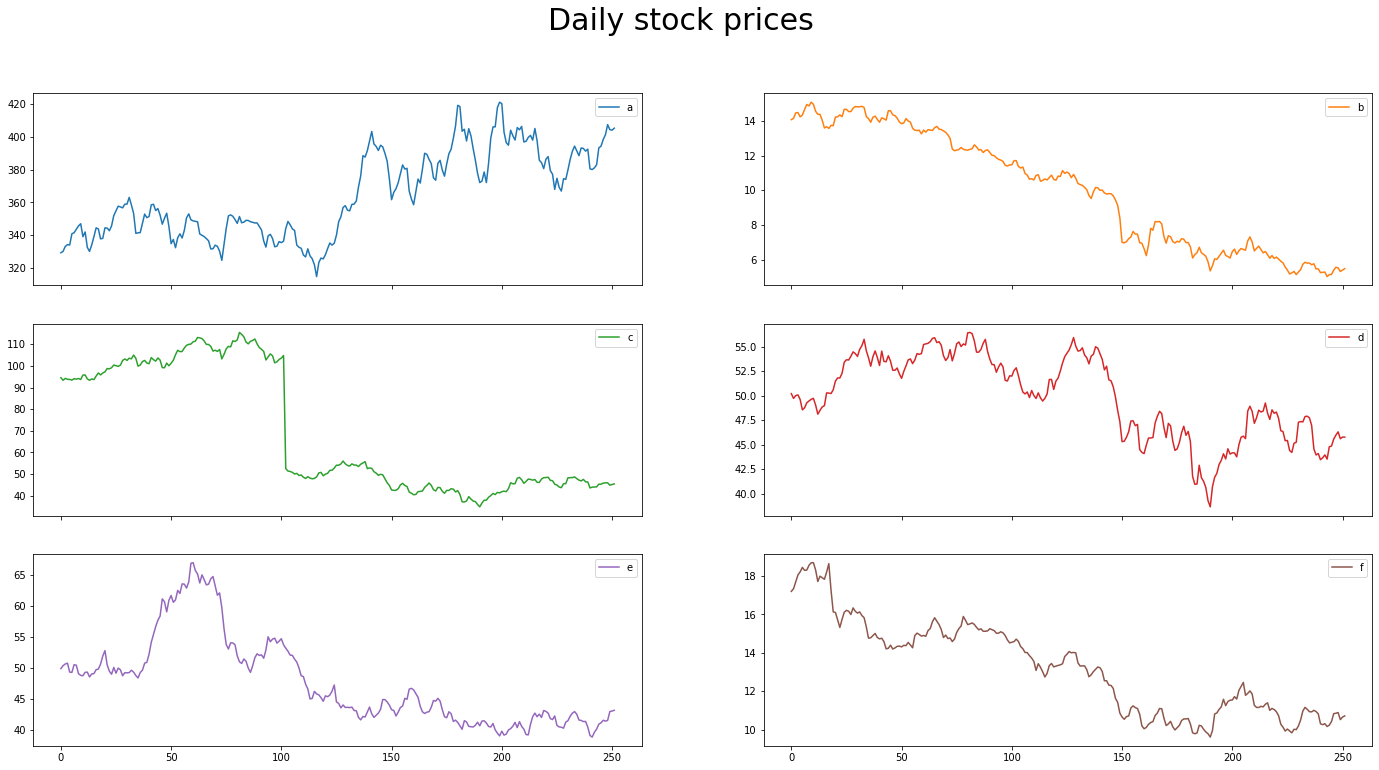

In [54]:
avgdata=pd.DataFrame(columns=raw_data.columns)
uniquedays=raw_data['day'].unique()
for dayiter in uniquedays:
    averaged_day=raw_data[raw_data['day']==dayiter].mean()
    avgdata=avgdata.append(averaged_day,ignore_index=True)
del avgdata['timestr']
del avgdata['day']
avgdata[stocks].plot(subplots=True, layout=(3, 2), figsize=(24, 12))
plt.gcf().suptitle("Daily stock prices",fontsize=30)
plt.show()

This analysis defines a monthly return for stock prices $S_t$ at time $t$ as 

$$r_t = \log{\left(\frac{S_{t}}{S_{t-m}}\right)}$$

where $S_{t-m}$ is the stock price one month before time $t$ ($m=21$), and $\it{log}$ returns are used. A rolling window of returns from days 21 to 252 is computed.

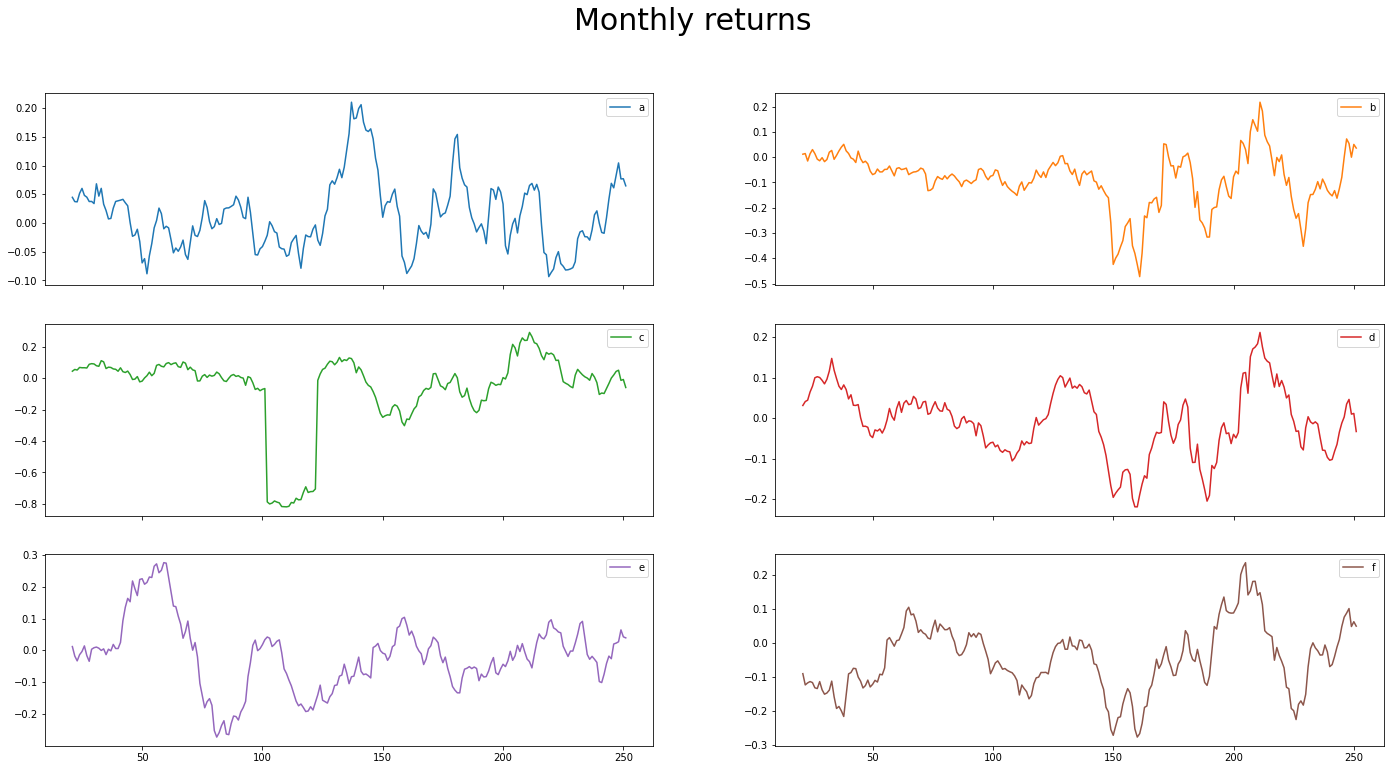

In [55]:
for stock in stocks:
    avgdata[stock]=np.log(avgdata[stock])
dayspermonth=21
data=avgdata.diff(periods=dayspermonth)
data=data.iloc[dayspermonth:]
data[stocks].plot(subplots=True, layout=(3, 2), figsize=(24, 12), use_index=True)
plt.gcf().suptitle("Monthly returns",fontsize=30)
plt.show()

The monthly returns are predictably relatively smooth, since neighboring returns have significant overlap in the stock prices included in their computation. An increase in volatility appears to occur for every stock sometime between trading days 120-150. A clear correlation between stocks b,c,d,f can be seen, with some possibly smaller correlation with stocks a and e as well. This correlation between stocks is acknowledged here, but is not included in the analysis performed. A multivariate approach would certainly improve the volatilities estimated from this analysis, and is left as an opportunity for future development.

## Modeling

Motivated by the expected serial correlation in monthly returns, as well as in volatility, the monthly returns are modeled by an Autoregressive (AR), General Autoregressive Conditional Heteroskedasticity (GARCH) model. The monthly return is modeled by an AR($\rho$) process,

$$r_t = c + \sum_i^{\rho} \varphi_i r_{t-i} + \epsilon_t$$

where $\rho$ lagged terms are included into the estimation. The residuals from the mean process are modeled as white noise scaled by the time dependent standard deviation.

$$\epsilon_t = \sigma_t z_t$$

$$z_t \sim N(0,1)$$

The time dependent variance is modeled by a GARCH(p,q) process which estimates the variance as a linear combination of lagged conditional and unconditional variances.

$$\sigma_t^2 = \omega + \sum_i^p \alpha_i \epsilon_{t-i}^2 + \sum_j^q \beta_j \sigma_{t-j}^2$$

With the use of the arch library (https://arch.readthedocs.io/en/latest/index.html), the returns are fit across a range of order space to identify the orders ($\rho$, p, q) which gives the best fit, estimated by the Akaike information criterion (AIC). Stock c are not well explained by this model due to the sharp drop in price in a single day, compared to the other stocks which have more gradual changes in their returns. Therefore, alternative to developing a more complex model, this analysis procedes by removing the monthly returns before day 126 (first five months of stock prices ignored) for stock c. The resulting parameters used by the six stocks are provided in the following table:

In [6]:
display(paramtable)

,c,phi1,phi2,phi3,omega,alpha,beta
a,0.000947,1.289011,-0.448324,0.080938,0.000008,0.010000,0.97
b,-0.004820,0.921352,,,0.000036,0.100003,0.879997
c,-0.001193,0.954162,,,0.001225,0.080844,
d,-0.000376,1.175340,-0.221411,,0.000005,0.056280,0.939941
e,-0.000421,1.237222,-0.275791,,0.000062,0.003080,0.906142
f,-0.002383,1.245564,-0.299397,,0.000011,0.037966,0.949535


In order to evaluate the fit, a few plots are shown for stock 'a'. The same plots are available in the appendix for the other five stocks. The plots below show the modeled returns vs the measured returns and the residuals of the model. In addition, the auto correlation of the residuals and the residuals squared are also shown to evaluate that the serial correlation of the returns and the return variance have been reduced. Some remaining autocorrelation with a lag of modulus 21 days is observed in both correlograms, suggesting that a correlation is left unmodeled. This is another potential improvement for this analysis which can be further investigated.

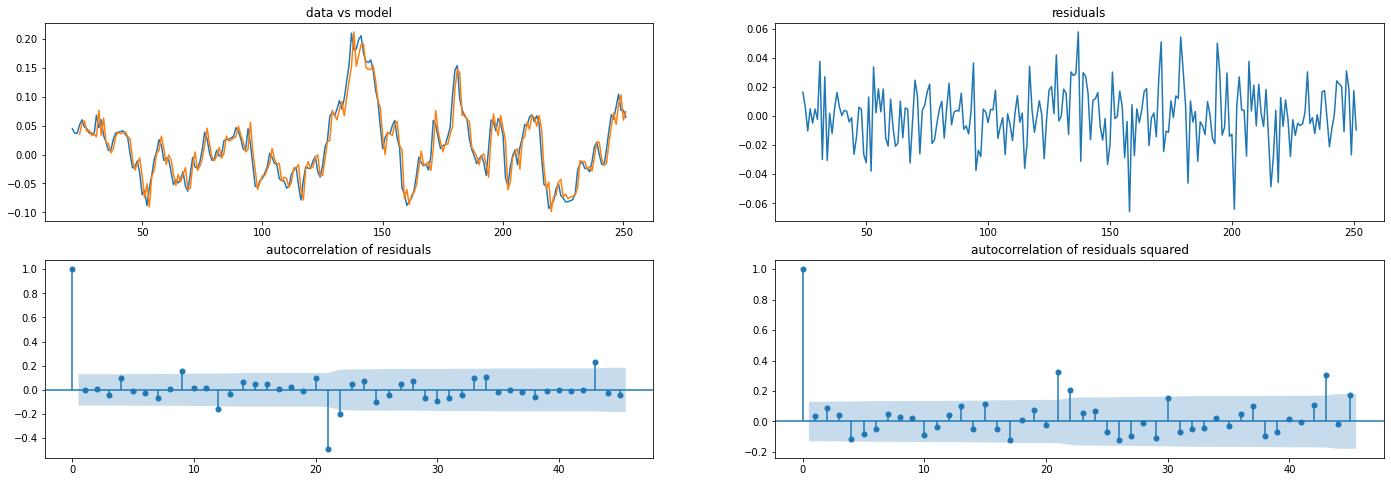

In [37]:
k=0
fig, ax = plt.subplots(2, 2, figsize=(24,8))
ax[0,0].plot(data[stocks[0]]),ax[0,0].plot(model[k]),ax[0,0].set_title("data vs model")
ax[0,1].plot(resid[k]),ax[0,1].set_title("residuals")
nlags=45
plot_acf(resid[k][3:],lags=nlags,ax=ax[1,0]),ax[1,0].set_title("autocorrelation of residuals")
plot_acf(np.square(resid[k][3:]),lags=nlags,ax=ax[1,1]),ax[1,1].set_title("autocorrelation of residuals squared")
plt.show()

## Results

Once the data is fitted to the model, the fitted parameters can be used to forecast future returns. Since the model has a white noise component, 1000 simulations are performed and the resulting distribution is used to construct both a point estimate and confidence intervals for the estimated volatility.

There are two definitions of volatility considered in this analysis: realized and conditional. Since volatility is a latent variable, it must be deduced from some sampling of the data. First, realized volatility is measured by sampling the monthly returns over some window and determining the standard deviation.

$$\sigma_{t}^{realized}=\frac{1}{N}\sum_i^N \left(r_{t-i} - \langle r_{t,N}\rangle \right)^2$$
$$\langle r_{t,N} \rangle = \frac{1}{N}\sum_i^N r_{t-i}$$

The plots below show the realized volatilities for the measured returns over a sampling window of one month prior, as well as the simulated realized volatilities and confidence intervals for the upcoming month. The requested realized volatility estimates 21 days after are shown in the table.

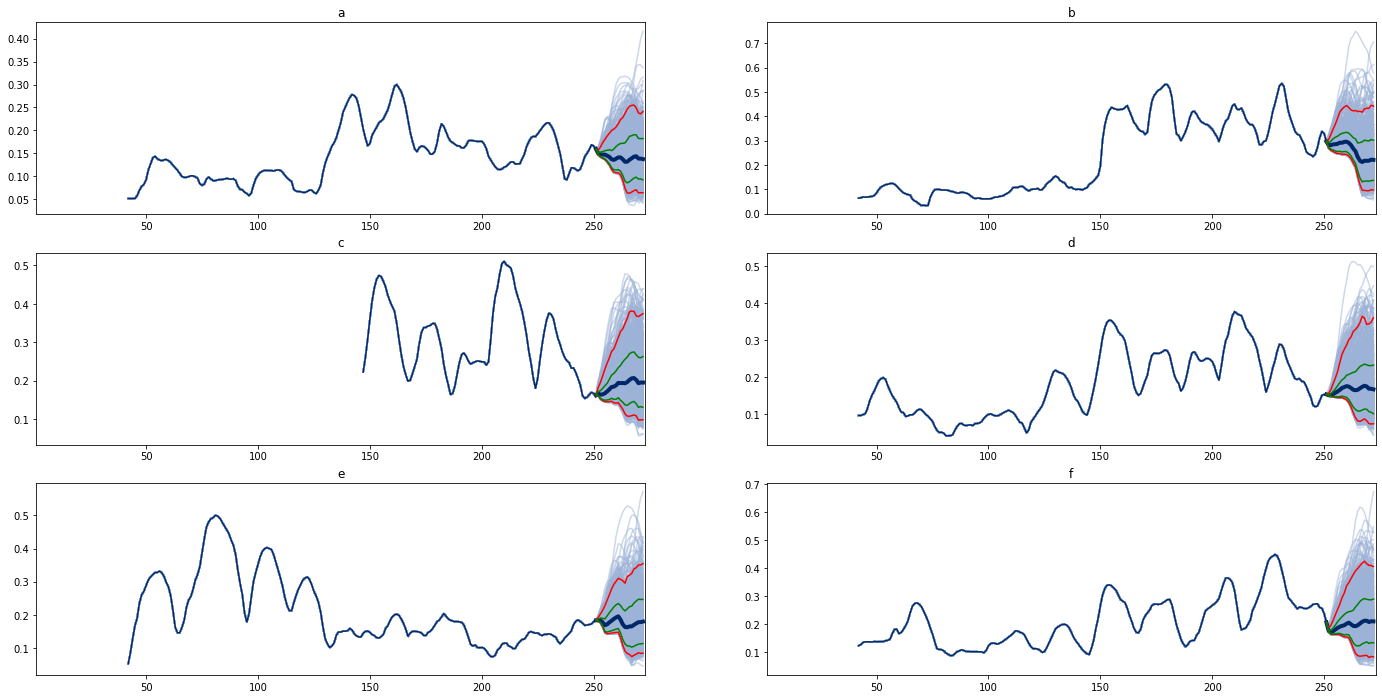

,Estimate,95% Lower Bound,95% Upper Bound
a,0.137558,0.064243,0.241251
b,0.220895,0.096974,0.441864
c,0.195058,0.098089,0.374490
d,0.167460,0.074528,0.360913
e,0.179997,0.085009,0.354387
f,0.209864,0.083102,0.405869


In [61]:
display(plot_realized_volatilities())

In addition to realized volatilities, the GARCH model estimates the inherent, exact-time conditional volatility of the return. The estimated conditional volatilities for the measured returns are now plotted, along with the simulation-based expected conditional volatilies and associated confidence intervals. The conditional volatility estimates 21 days after are shown in the table.

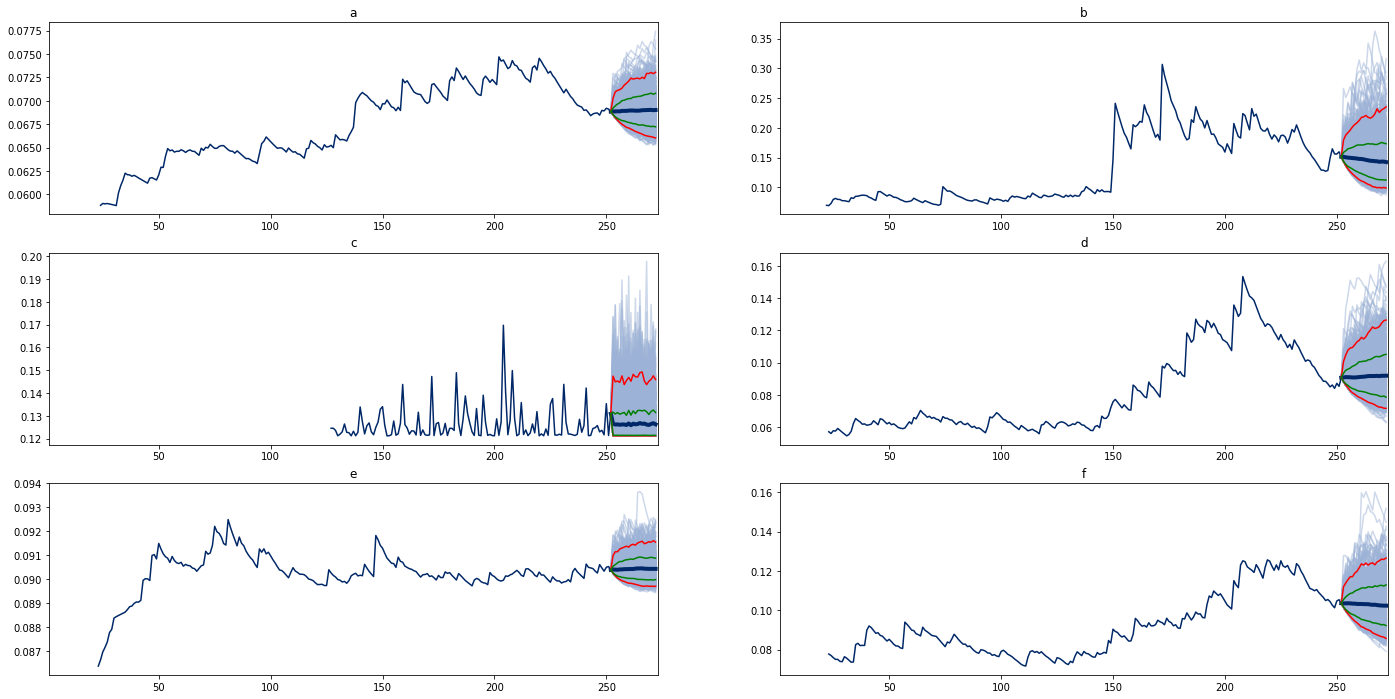

,Estimate,95% Lower Bound,95% Upper Bound
a,0.069016,0.066030,0.073050
b,0.142575,0.098871,0.235324
c,0.126282,0.121230,0.145925
d,0.091905,0.071702,0.126409
e,0.090432,0.089707,0.091544
f,0.102359,0.085661,0.126607


In [60]:
display(plot_conditional_volatilities())

## Conclusion

The AR-GARCH model successfully identified the increase in volatility of the returns. The point estimates and confidence intervals provided assume that the model correctly describes the behavior of the monthly returns. Next steps would be to evaluate the accuracy of the model on future data, and compare the predicted returns and volatilities with the measured ones. 

This was my first time modeling time series data, and there were a number of potential improvements I identified along the way. A multivariate approach would be the first thing I would investigate, since a correlation between stock prices can easily be seen. I would also consider variants of the GARCH model which may better explain the expected data, for example the seasonal dependence of volatility. Another alteration would be needed to explain steep changes in price, as seen in stock c, which the AR-GARCH model is currently unable to represent.

## References

The following references were valuable to me in completing this exercise:

https://arch.readthedocs.io/en/latest/index.html

https://www.stern.nyu.edu/rengle/EnglePattonQF.pdf

https://www.quantstart.com/articles/Generalised-Autoregressive-Conditional-Heteroskedasticity-GARCH-p-q-Models-for-Time-Series-Analysis/

https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/







In [1]:
import numpy as np
import pandas as pd
import math
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 8]
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [5]:
rhoarray=[3,1,1,2,2,2]
parray=[1,1,1,1,1,1]
qarray=[1,1,0,1,1,1]
model=[]
resid=[]

paramtable=pd.DataFrame({},columns=['c','phi1','phi2','phi3','omega','alpha','beta'])

nsims=1000

startmonth=[0,0,5,0,0,0]
endmonth=[11,11,11,11,11,11]
#dayspermonth=21
scaling=np.sqrt(12)
realization_window=21
simulated_horizon=21#must be geq realization_window

k_realized_vol=[]
k_mean_realized_vol=[]
k_upperconf68=[]
k_lowerconf68=[]
k_upperconf95=[]
k_lowerconf95=[]
k_sims=[]
k_past_conditional_vol=[]
k_forecasted_conditional_vol=[]

for k in range(0,len(stocks)):
    stock=stocks[k]
    ar=arch_model(data[stock].iloc[startmonth[k]*dayspermonth:], mean='AR', lags=rhoarray[k], vol='Garch', p=parray[k], q=qarray[k])
    res = ar.fit(disp='off')
    
    #add parameters to table for producing writeup
    if(stock=='a'):
        paramtable.loc[stock]=[res.params[0],res.params[1],res.params[2],res.params[3],res.params[4],res.params[5],res.params[6]]
    elif(stock=='b'):
        paramtable.loc[stock]=[res.params[0],res.params[1],"","",res.params[2],res.params[3],res.params[4]]
    elif(stock=='c'):
        paramtable.loc[stock]=[res.params[0],res.params[1],"","",res.params[2],res.params[3],""]
    else:
        paramtable.loc[stock]=[res.params[0],res.params[1],res.params[2],"",res.params[3],res.params[4],res.params[5]]
    
    model.append(data[stock]-res.resid)
    resid.append(res.resid)
    forecasts = res.forecast(horizon=simulated_horizon, method='simulation', simulations=nsims)
    sims=forecasts.simulations
    
    realized_vol=[]
    if(realization_window > dayspermonth*(endmonth[k]-startmonth[k])):
        print("error")
        exit()

    for j in range(0,nsims):
        realized_vol.append([])
        
        #calculate previous realized volatility
        for i in range(dayspermonth*startmonth[k],(dayspermonth*endmonth[k])-realization_window):
            realized_vol[j].append(scaling*np.std(data[stock].iloc[i:i+realization_window]))
        #calculate simulated realized volatility    
        for i in range(0,realization_window):
            templist=data[stock].iloc[((dayspermonth*endmonth[k])-realization_window)+i:((dayspermonth*endmonth[k]))].values
            templist=np.append(templist,sims.values[-1,j,0:i+1])
            realized_vol[j].append(scaling*np.std(templist))
        for i in range(realization_window, simulated_horizon):
            templist=sims.values[-1,j,simulated_horizon-i:i+1]
            realized_vol[j].append(scaling*np.std(templist))
    realized_vol=np.asarray(realized_vol)
    mean_realized_vol=np.mean(realized_vol, axis=0)
    
    #store data for later plotting
    k_realized_vol.append(realized_vol)
    k_mean_realized_vol.append(mean_realized_vol)
    #k_upperconf68.append(upperconf68)
    #k_lowerconf68.append(lowerconf68)
    #k_upperconf95.append(upperconf95)
    #k_lowerconf95.append(lowerconf95)
    
    k_sims.append(scaling*sims.values[-1].T)
    
    k_past_conditional_vol.append(scaling*res.conditional_volatility.values)
    k_forecasted_conditional_vol.append(scaling*np.sqrt(sims.residual_variances[-1]))
    
    

/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001795. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_

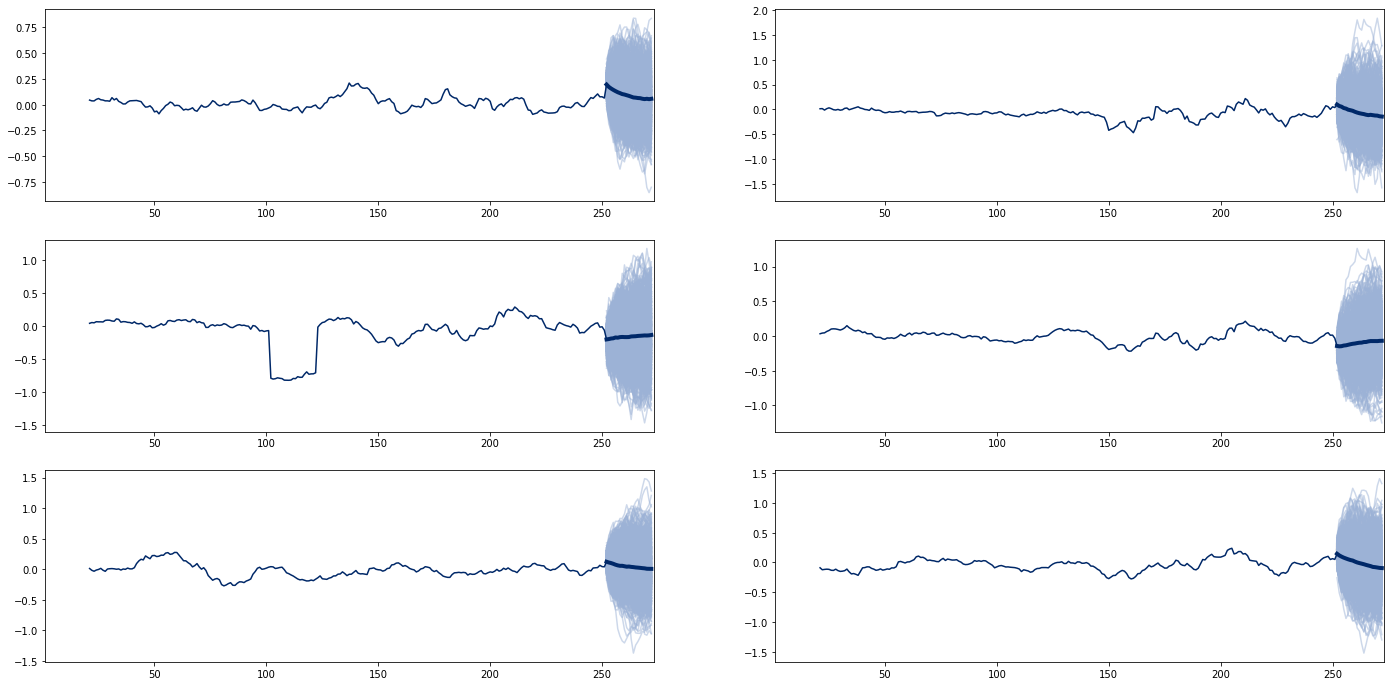

In [59]:
plot_forecasted_returns()

In [56]:
def plot_realized_volatilities():
    realizedvoltable=pd.DataFrame({},columns=['Estimate','95% Lower Bound','95% Upper Bound'])
    fig, ax = plt.subplots(3, 2, figsize=(24,12))
    for k in range(0,6):
        #plot realized volatility
        startday=(startmonth[k]+1)*dayspermonth + realization_window
        endday=(endmonth[k]+1)*dayspermonth + simulated_horizon
        daylist=np.arange(startday,endday,1)     
        lines = ax[k//2,k%2].plot(daylist, np.asarray(k_realized_vol[k]).T, color='#9cb2d6', alpha=0.5)
        lines[0].set_label('Simulated paths')

        endday=(endmonth[k]+1)*dayspermonth
        daylist=np.arange(startday,endday,1)
        line=ax[k//2,k%2].plot(daylist, np.asarray(k_mean_realized_vol)[k][0:(endmonth[k]-startmonth[k])*dayspermonth - realization_window], color='#002868')
        line[0].set_label('Measured realized volatility')

        startday=(endmonth[k]+1)*dayspermonth-1
        endday=startday+1+simulated_horizon
        daylist=np.arange(startday,endday,1)
        line=ax[k//2,k%2].plot(daylist ,np.asarray(k_mean_realized_vol)[k][(endmonth[k]-startmonth[k])*dayspermonth - realization_window - 1:], color='#002868', lw=4)
        line[0].set_label('Expected realized volatility')

        simulation_start_index=((endmonth[k]-1)-startmonth[k])*dayspermonth
        #add these points to make plots nice
        upperconf68=[k_mean_realized_vol[k][simulation_start_index-1]]
        lowerconf68=[k_mean_realized_vol[k][simulation_start_index-1]]
        upperconf95=[k_mean_realized_vol[k][simulation_start_index-1]]
        lowerconf95=[k_mean_realized_vol[k][simulation_start_index-1]]

        for j in range(simulation_start_index,simulation_start_index+simulated_horizon):
            sortedvals=np.sort(k_realized_vol[k][:,j])
            upperconf68.append(sortedvals[int(.84*nsims)])
            lowerconf68.append(sortedvals[int(.16*nsims)])
            upperconf95.append(sortedvals[int(.975*nsims)])
            lowerconf95.append(sortedvals[int(.025*nsims)])

        line=ax[k//2,k%2].plot(daylist, upperconf95, color='r')
        line=ax[k//2,k%2].plot(daylist, lowerconf95, color='r')
        line[0].set_label('95% confidence interval')
        line=ax[k//2,k%2].plot(daylist, upperconf68, color='g')
        line=ax[k//2,k%2].plot(daylist, lowerconf68, color='g')
        line[0].set_label('68% confidence interval')

        ax[k//2,k%2].set_title(stocks[k])
        #plt.gca().set_xticks(x)
        ax[k//2,k%2].set_xlim(1,(endmonth[k]+1)*dayspermonth+simulated_horizon)
        
        realizedvoltable.loc[stocks[k]]=[k_mean_realized_vol[k][-1],lowerconf95[-1],upperconf95[-1]]
    #plt.legend()
    plt.show()
    return realizedvoltable
    #return conf
        #return([k_mean_realized_vol[k][-1],lowerconf95[-1],upperconf95[-1]])
        #print("Simulated realized volatility one month after: "+str(k_mean_realized_vol[k][-1])+" with 95% CI: ["+str(lowerconf95[-1])+", "+str(upperconf95[-1])+"]")



In [57]:
def plot_conditional_volatilities():
    conditionalvoltable=pd.DataFrame({},columns=['Estimate','95% Lower Bound','95% Upper Bound'])
    fig, ax = plt.subplots(3, 2, figsize=(24,12))
    for k in range(0,6):


        mean_forecasted_conditional_vol=np.mean(k_forecasted_conditional_vol[k],axis=0)
        pastvol=np.append(k_past_conditional_vol[k],mean_forecasted_conditional_vol[0])

        startday=(startmonth[k]+1)*dayspermonth
        endday=(endmonth[k]+1)*dayspermonth+1
        daylist=np.arange(startday,endday,1)   
        line=ax[k//2,k%2].plot(daylist, pastvol, color='#002868')
        line[0].set_label('Fitted past conditional volatility')

        startday=(endmonth[k]+1)*dayspermonth
        endday=startday+simulated_horizon
        daylist=np.arange(startday,endday,1)
        lines = ax[k//2,k%2].plot(daylist, k_forecasted_conditional_vol[k].T, color='#9cb2d6', alpha=0.5)
        lines[0].set_label('Simulated forecasted conditional volatility')
        line=ax[k//2,k%2].plot(daylist, mean_forecasted_conditional_vol, color='#002868', lw=4)
        line[0].set_label('Fitted forecasted conditional volatility')


        simulation_start_index=((endmonth[k]-1)-startmonth[k])*dayspermonth
        #add these points to make plots nice
        upperconf68=[]
        lowerconf68=[]
        upperconf95=[]
        lowerconf95=[]
        #upperconf68=[k_past_conditional_vol[k][simulation_start_index-1]]
        #lowerconf68=[k_past_conditional_vol[k][simulation_start_index-1]]
        #upperconf95=[k_past_conditional_vol[k][simulation_start_index-1]]
        #lowerconf95=[k_past_conditional_vol[k][simulation_start_index-1]]

        for j in range(0,simulated_horizon):
            sortedvals=np.sort(k_forecasted_conditional_vol[k][:,j])
            upperconf68.append(sortedvals[int(.84*nsims)])
            lowerconf68.append(sortedvals[int(.16*nsims)])
            upperconf95.append(sortedvals[int(.975*nsims)])
            lowerconf95.append(sortedvals[int(.025*nsims)])

        startday=(endmonth[k]+1)*dayspermonth
        endday=(endmonth[k]+1)*dayspermonth+simulated_horizon
        daylist=np.arange(startday,endday,1)  

        line=ax[k//2,k%2].plot(daylist, upperconf95, color='r')
        line=ax[k//2,k%2].plot(daylist, lowerconf95, color='r')
        line[0].set_label('95% confidence interval')
        line=ax[k//2,k%2].plot(daylist, upperconf68, color='g')
        line=ax[k//2,k%2].plot(daylist, lowerconf68, color='g')
        line[0].set_label('68% confidence interval')

        ax[k//2,k%2].set_title(stocks[k])
        ax[k//2,k%2].set_xlim(1,(endmonth[k]+1)*dayspermonth+simulated_horizon)
        conditionalvoltable.loc[stocks[k]]=[mean_forecasted_conditional_vol[-1],lowerconf95[-1],upperconf95[-1]]

#plt.legend()
    plt.show()
    return conditionalvoltable


#print("Simulated conditional volatility one month after: "+str(mean_forecasted_conditional_vol[-1])+" with 95% CI: ["+str(lowerconf95[-1])+", "+str(upperconf95[-1])+"]")


In [58]:
def plot_forecasted_returns():

    fig, ax = plt.subplots(3, 2, figsize=(24,12))
    for k in range(0,6):

        meanreturn=np.mean(k_sims[k].T,axis=0)
        startday=(endmonth[k]+1)*dayspermonth
        endday=startday+simulated_horizon
        daylist=np.arange(startday,endday,1)  

        lines = ax[k//2,k%2].plot(daylist, k_sims[k], color='#9cb2d6', alpha=0.5)
        lines[0].set_label('Simulated paths')

        pastreturns=np.append(data[stocks[k]],meanreturn[0])
        startday=dayspermonth#(startmonth[k]+1)*dayspermonth
        endday=(endmonth[k]+1)*dayspermonth+1
        daylist=np.arange(startday,endday,1)  
        line=ax[k//2,k%2].plot(daylist, pastreturns, color='#002868')
        line[0].set_label('Measured return')

        startday=(endmonth[k]+1)*dayspermonth
        endday=startday+simulated_horizon
        daylist=np.arange(startday,endday,1) 

        line=ax[k//2,k%2].plot(daylist ,meanreturn, color='#002868', lw=4)
        line[0].set_label('Expected return')

        ax[k//2,k%2].set_xlim(1,(endmonth[k]+1)*dayspermonth+simulated_horizon)
        #plt.legend()
    plt.show()






In [234]:
#data exploration

print(raw_data[raw_data['timestr']=='09:30:00']['day'].nunique())
print(raw_data[raw_data['timestr']=='16:00:00']['day'].nunique())

#print(raw_data.info())
print(raw_data.describe(include='all'))
print(raw_data.head())
print(raw_data.tail())

raw_data['day'].nunique()

252
251
                day   timestr             a             b             c  \
count   98352.00000     98352  98188.000000  98352.000000  98321.000000   
unique          NaN       391           NaN           NaN           NaN   
top             NaN  11:30:00           NaN           NaN           NaN   
freq            NaN       252           NaN           NaN           NaN   
mean      181.29732       NaN    364.112284     10.048836     69.445570   
std       104.61705       NaN     25.983384      3.332643     28.675762   
min         1.00000       NaN    311.400000      4.885000     33.807000   
25%        89.00000       NaN    341.850000      6.605000     45.330000   
50%       180.00000       NaN    357.935000     10.595000     50.960000   
75%       271.00000       NaN    387.905000     13.465000    101.905000   
max       362.00000       NaN    426.560000     15.335000    116.385000   

                   d             e             f  
count   98241.000000  98352.000000  9698

252

There are 98352 total datapoints over a day range of 1 to 362, and a time range each day of 9:30 to 16:00 with 391 minute datapoints in each day. There are 252 unique trading days, however 98535 modulus 391 is not zero, hence some days must be missing data. The missing time is caused by an early closing of the market presumably for Thanksgiving at 13:00. Addition of the missing 180 datapoints now completes the modulus.

In [291]:
#day 372 - presumably thanksgiving. last datapoint is at 1pm.
print(raw_data[raw_data['day']==327].tail())

#confirm that with 180 missing datapoints, total datapoints ends up being correct.
print((98352.+180.)/391.)
print(raw_data['day'].nunique())


       day   timestr        a      b       c       d      e      f
88963  327  12:56:00  364.570  5.115  43.413  43.935  40.24  9.765
88964  327  12:57:00  364.700  5.115  43.405  43.875  40.24  9.765
88965  327  12:58:00  364.545  5.215  43.405  43.865  40.27  9.765
88966  327  12:59:00  364.380  5.125  43.325  43.855  40.33  9.765
88967  327  13:00:00  363.580  5.225  43.333  43.835  40.31  9.765
252.0
252


The days can also be determined to be weekdays when looking at their modulus of a week. Most of the holidays occur on Monday, with just one holiday on Thursday and Friday each.

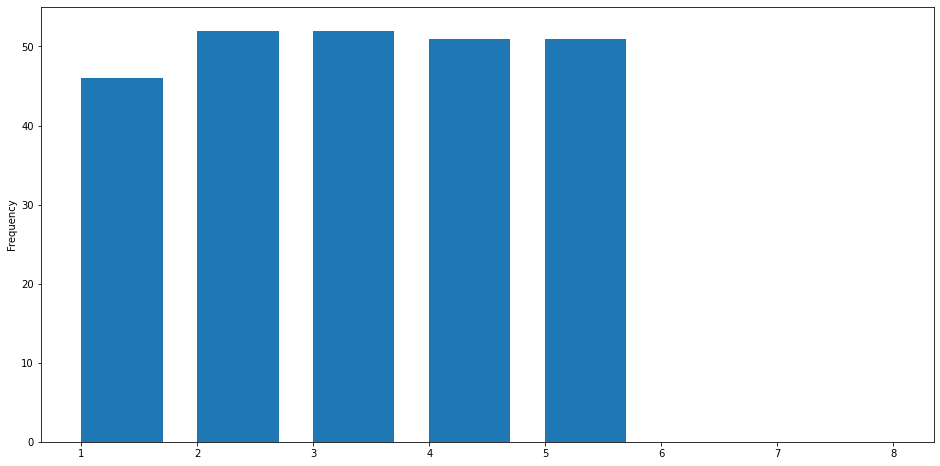

In [8]:
#evaluate mon-fri periodicity
raw_data[raw_data['timestr'] == '09:30:00']['day'].mod(7).plot.hist(range=[1, 8],bins=7,ylim=(0,55),width=0.7) #add labels,fix offset, make nicer
plt.show()

Now let's evaluate the stock prices. From the description of the pandas dataframe, stocks 'a' and 'd' are expected to have unusual stock values of 0 and 1 respectively. Only stocks 'b' and 'e' do not have missing data. It is good to visualize what this data looks like.

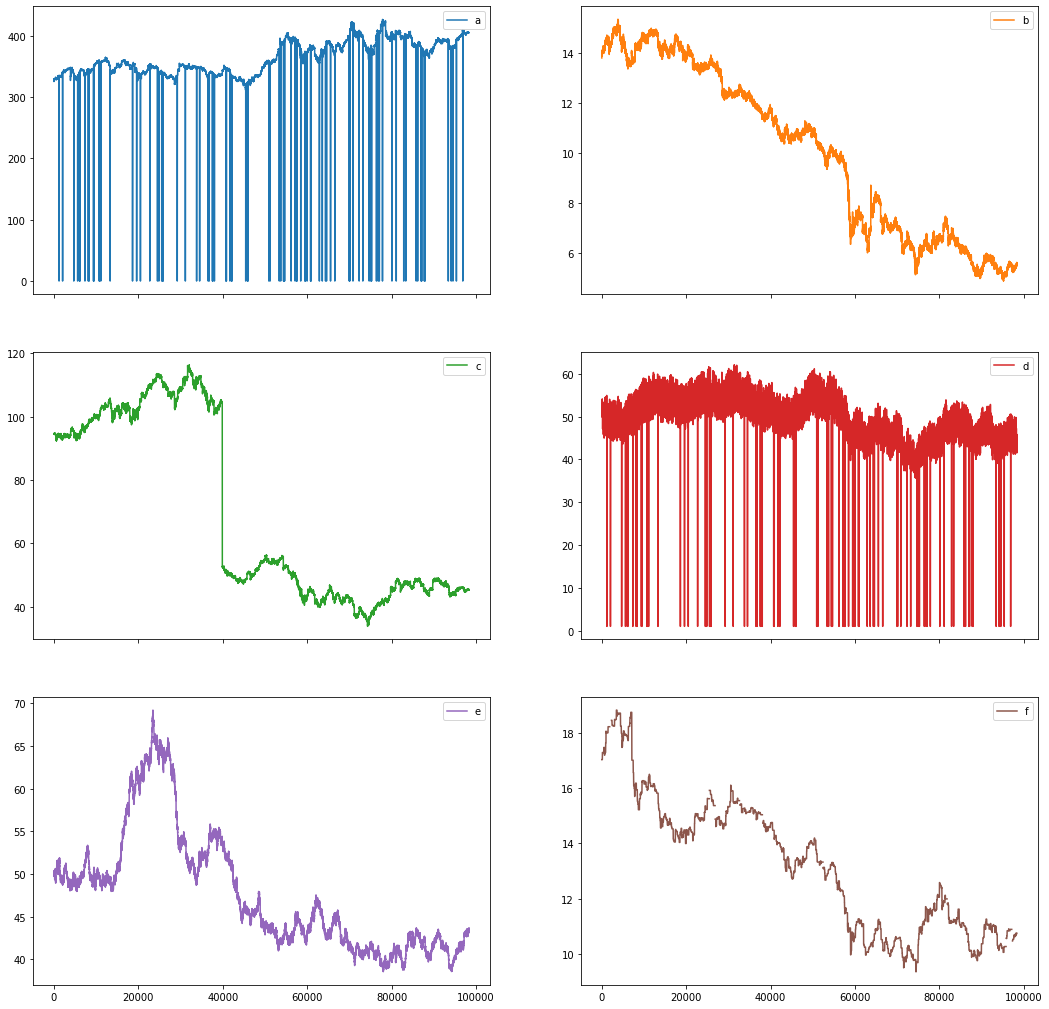

In [153]:
stocks=['a','b','c','d','e','f']
raw_data[stocks].plot(subplots=True, layout=(3, 2), figsize=(18, 18))
plt.show()

#for stock in stocks:
#    raw_data.plot(y=stock)
#    plt.show()

The unphysical drops in price for stocks 'a' and 'd' can be seen. These are first removed by replacing the values with NaN.

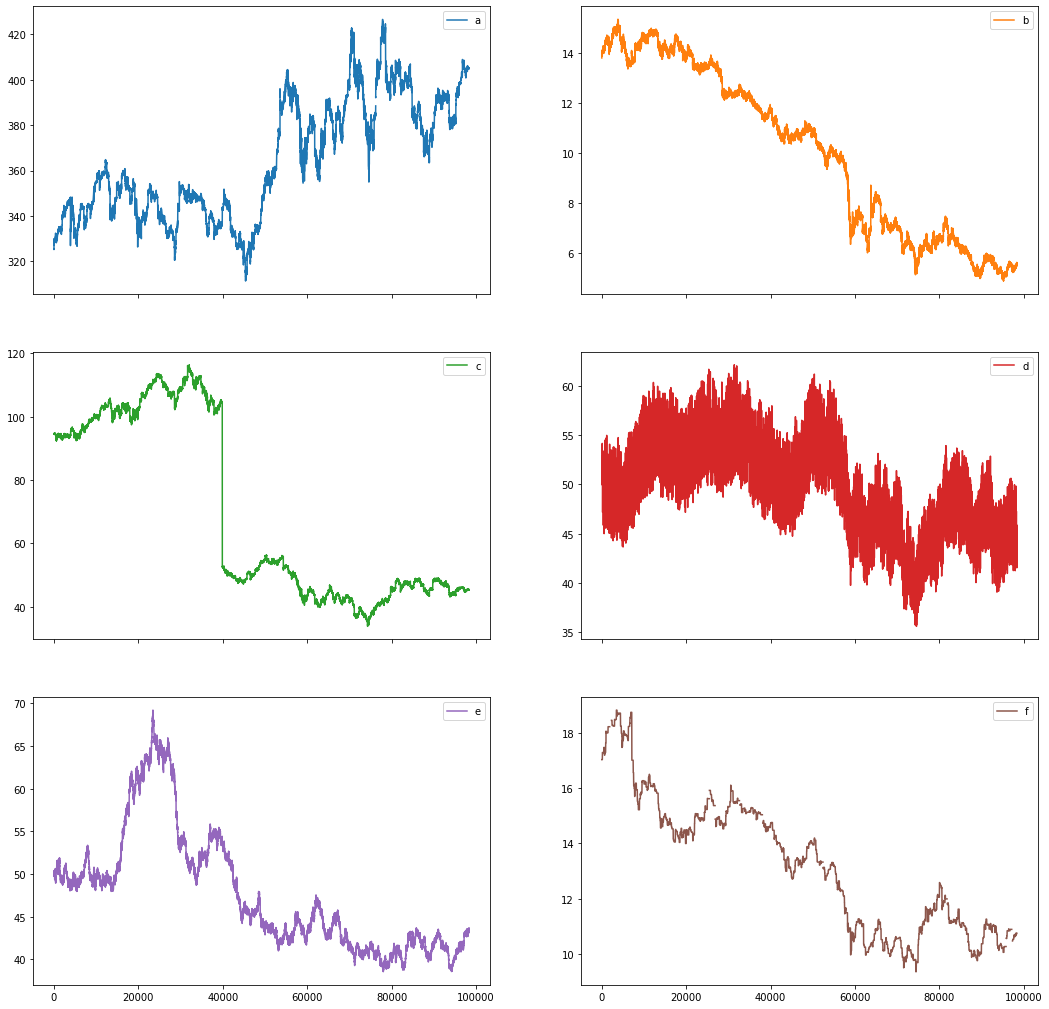

In [154]:
raw_data['a'] = raw_data['a'].replace(0, np.nan)
raw_data['d'] = raw_data['d'].replace(1, np.nan)

raw_data[stocks].plot(subplots=True, layout=(3, 2), figsize=(18, 18))
plt.show()

Now the missing data is standardized with the form NaN for all stocks. The procedure developed here will take the daily average of the stock prices in order to reduce the amount of data for processing. This averaging will handle the missing data by simply ignoring it in the averaging, however we should make sure that each day has enough non-missing data to make a reasonable estimate.

In [5]:
for stock in ['a','c','d','f']:
    mostfrequentday=raw_data[raw_data[stock].isna()]['day'].value_counts()[:1].index.tolist()[0]
    print(raw_data[(raw_data['day']==mostfrequentday) & (raw_data[stock].isna())]['day'].count())

35
11
11
337


Stocks a,c,d have at worst a small percentage of the 391 daily datapoints missing. Stock f, however, has a high number of missing datapoints on day 8. Upon closer inspection, this missing data is carried over from the prior trading day, and the values seen are very similar to the neighboring days. Therefore, the average is still taken with the reduced data. Now we create a new dataframe of the averaged daily prices. A possible improvement of this procedure is to include the trading volume into a weighted average.

Based on the observed behavior of the stock prices demonstrating some memory, we may expect serial correlation and so we plot the correlograms.

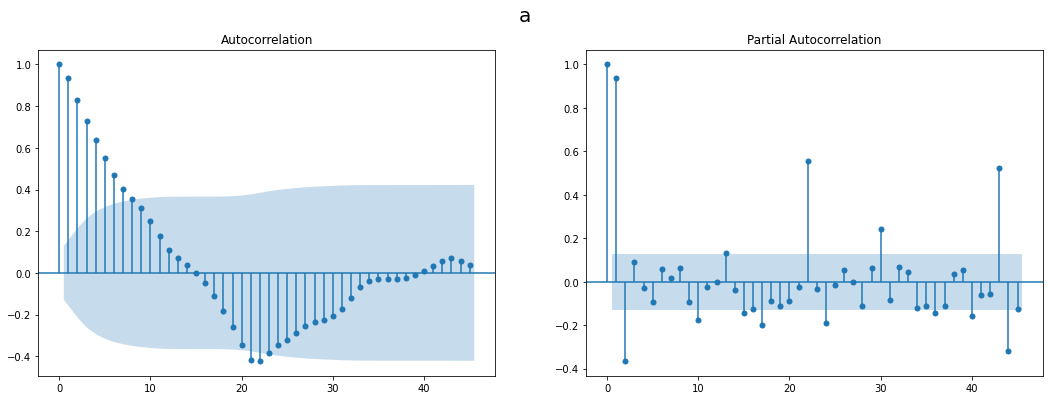

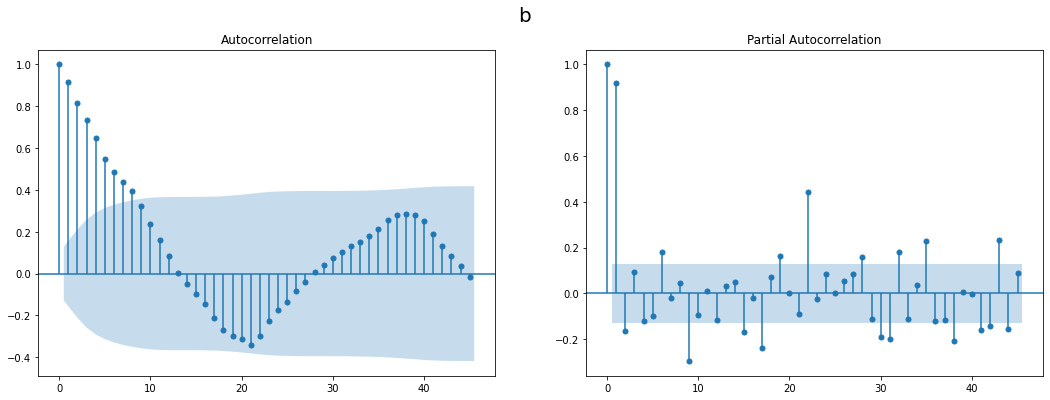

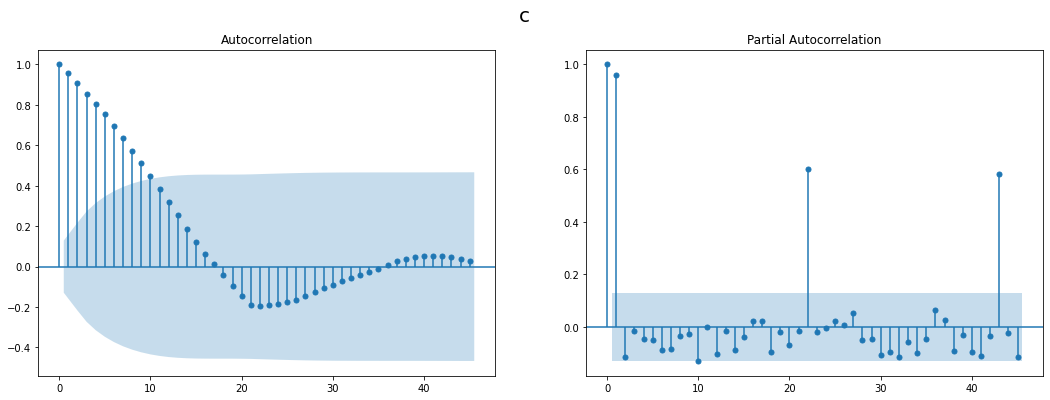

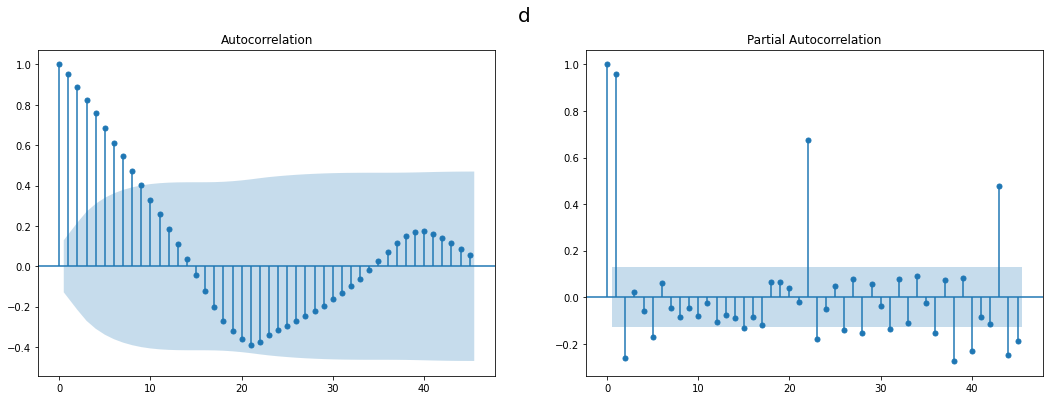

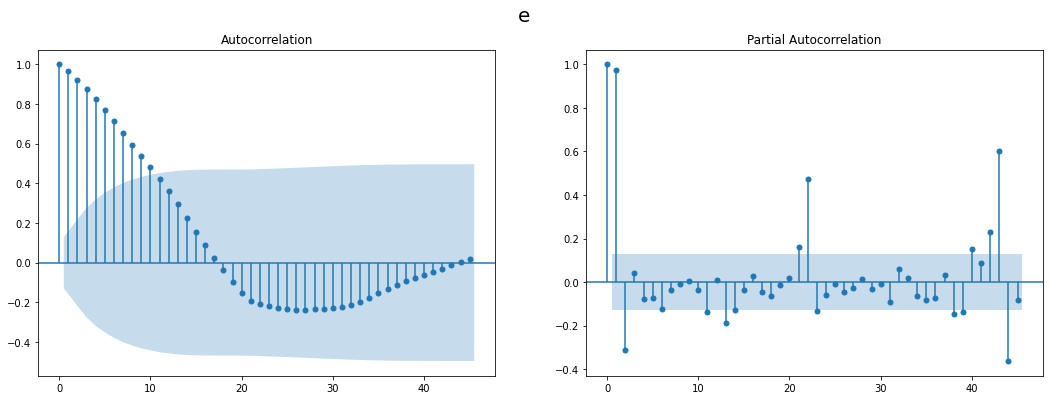

/home/brandon/.local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


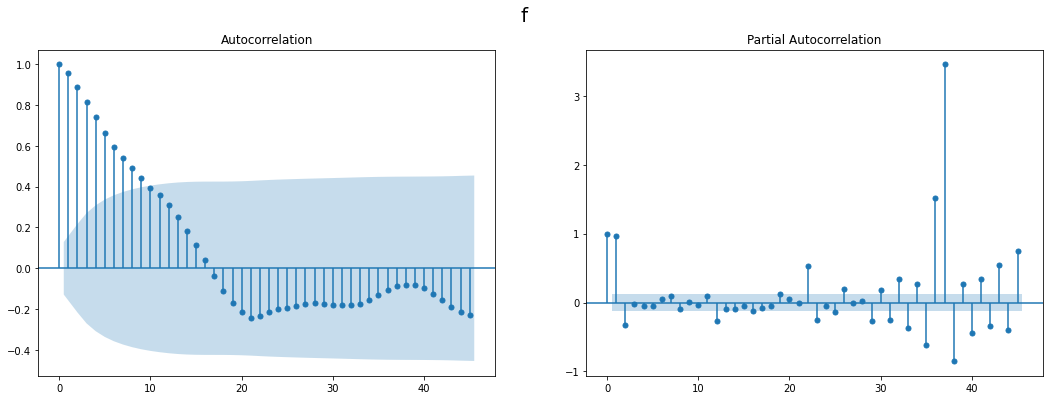

In [292]:
nlags=45
for stock in stocks:
    fig, ax = plt.subplots(1, 2, figsize=(18,6))
    fig.suptitle(stock, fontsize=20)
    plot_acf(data[stock],lags=nlags,ax=ax[0])
    plot_pacf(data[stock],lags=nlags,ax=ax[1])
    plt.show()

The autocorrelation plots demonstrate, as expected, some significant autocorrelation of the returns which we will model using an ARMA(p,q) process. In addition, the partial autocorrelation plot identifies a monthly periodic correlation, which is expected considering the returns are defined by monthly spacing.

The serial correlation has been removed (for the most part)

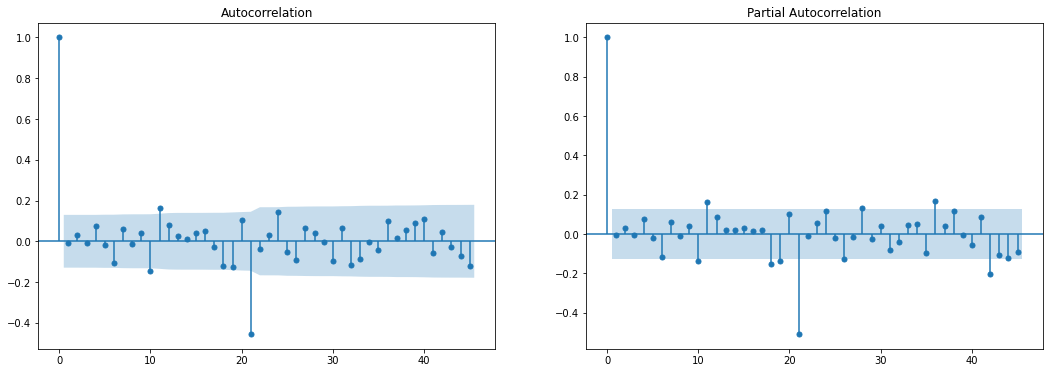

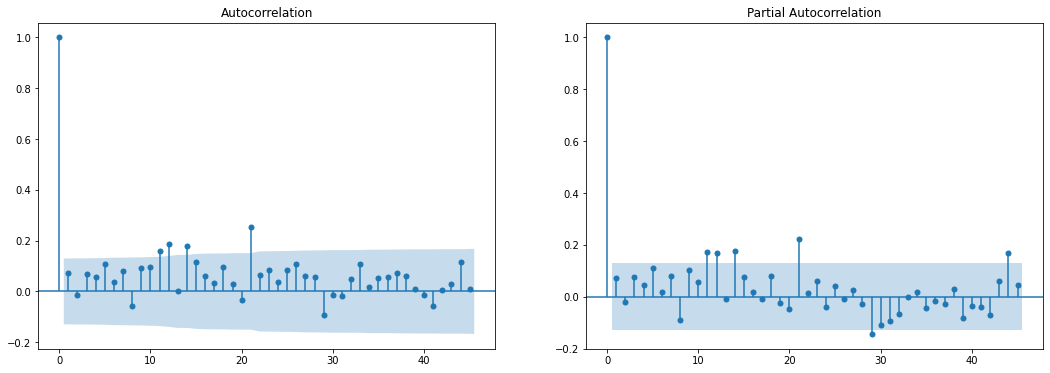

In [173]:
nlags=45
#for model in bestmodels:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
#fig.suptitle(stock, fontsize=20)
plot_acf(res.resid.iloc[2:],lags=nlags,ax=ax[0])
plot_pacf(res.resid.iloc[2:],lags=nlags,ax=ax[1])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(18,6))
#fig.suptitle(stock, fontsize=20)
plot_acf(np.square(res.resid.iloc[2:]),lags=nlags,ax=ax[0])
plot_pacf(np.square(res.resid.iloc[2:]),lags=nlags,ax=ax[1])
plt.show()

/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003985. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:      8,   Neg. LLF: 66661173.96682354
Iteration:      2,   Func. Count:     21,   Neg. LLF: 5744.243321600788
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2603489.11563203
Iteration:      4,   Func. Count:     46,   Neg. LLF: 70.95274084046092
Iteration:      5,   Func. Count:     57,   Neg. LLF: 657631.6687868024
Iteration:      6,   Func. Count:     67,   Neg. LLF: 250.22733581087564
Iteration:      7,   Func. Count:     78,   Neg. LLF: 3316.5256007563876
Iteration:      8,   Func. Count:     88,   Neg. LLF: -101.5525876475241
Iteration:      9,   Func. Count:     98,   Neg. LLF: -27.869797443463998
Iteration:     10,   Func. Count:    108,   Neg. LLF: -481.10719250305397
Iteration:     11,   Func. Count:    117,   Neg. LLF: 139985963.04637766
Iteration:     12,   Func. Count:    126,   Neg. LLF: -573.0158740540656
Iteration:     13,   Func. Count:    134,   Neg. LLF: -558.1759223613335
Iteration:     14,   Func. Count:    143,   Neg. LLF: -

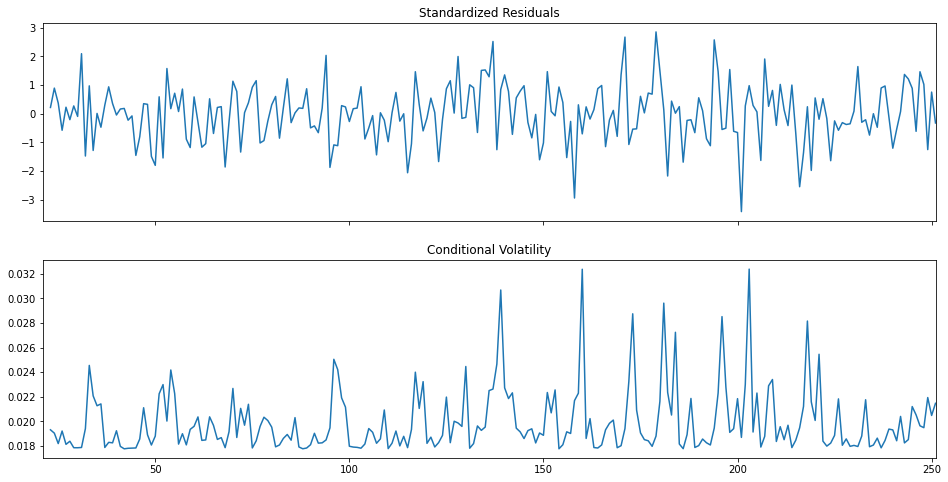

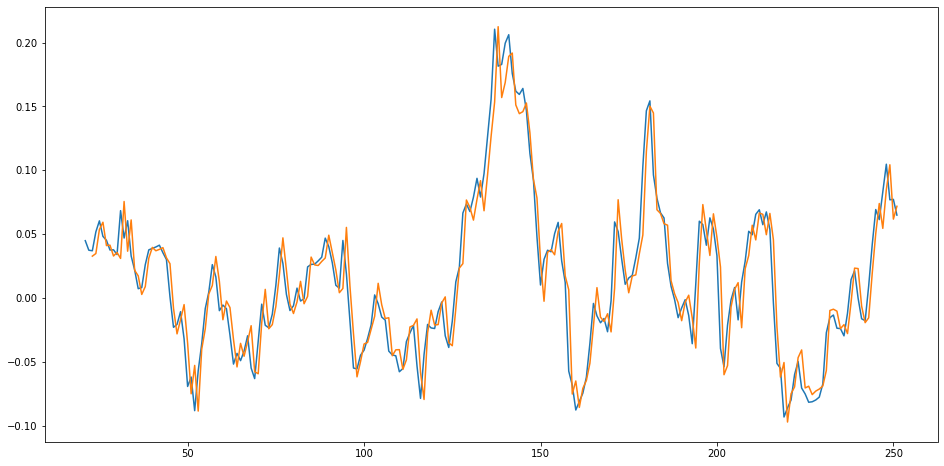

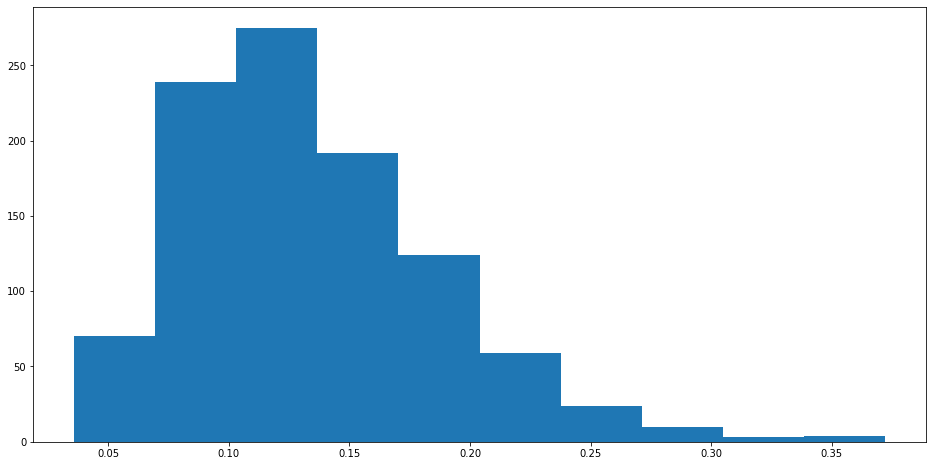

simulated "measured" volatility over last month (not the innate vol) (nsims shown)
0.1349460564092116
[0.0591786 0.2615996]


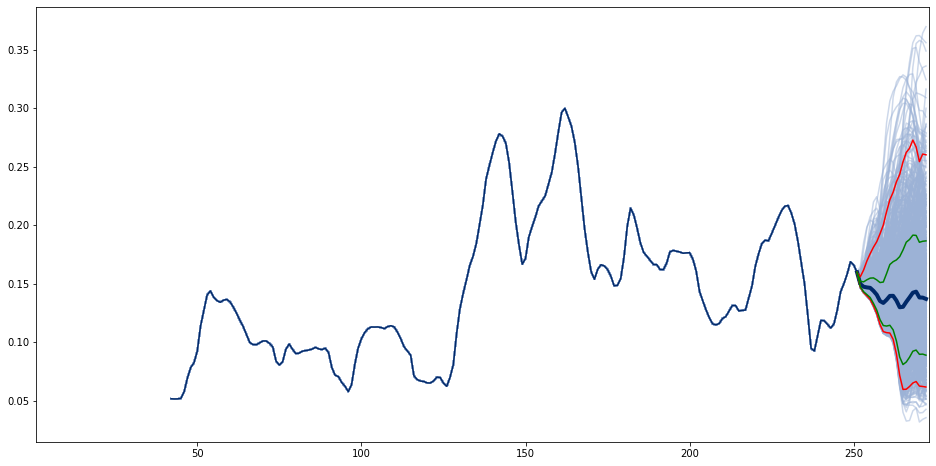

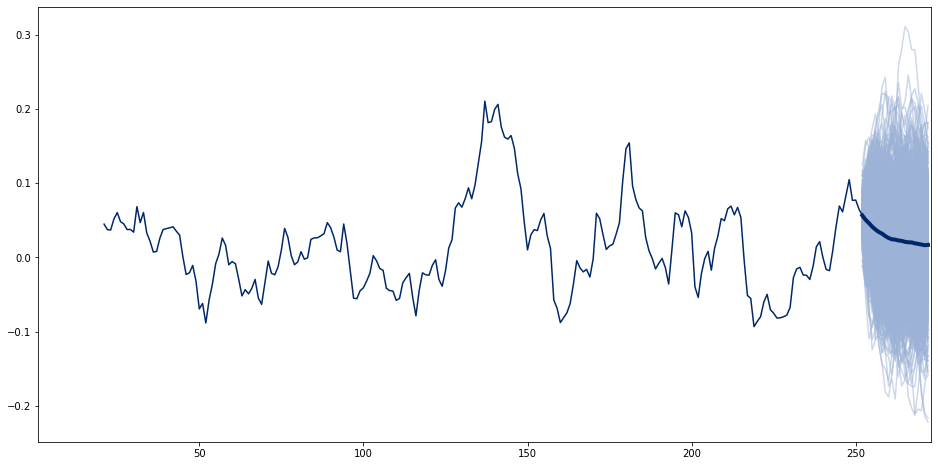

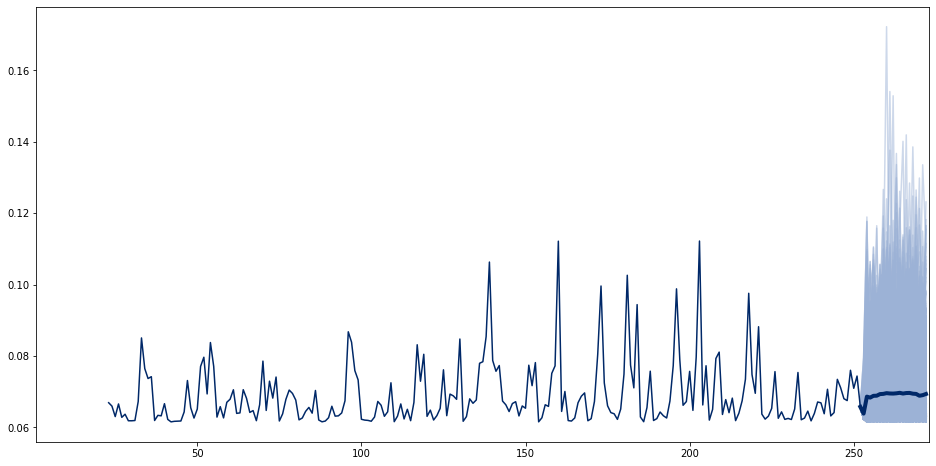

0.06932881598242419
[0.06167848 0.09331497]
compare this to measured volatility from the year (Affected by large changes in price)
0.20906266417117558
compare this to measured volatilities from 11 one-month samples
[0.05163189 0.11853632 0.09330858 0.11299959 0.06231658 0.20311171
 0.19688885 0.16631305 0.12018375 0.21005503 0.1502693 ]


In [43]:
#simultaneous fitting

#stock='a'
#ar=arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=2, q=0)

#stock='b'
#ar=arch_model(data[stock], mean='AR', lags=1, vol='Garch', p=1, q=1)

#stock='c'
#data['c']=data['c'].iloc[110:]
#ar=arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=1, q=0)

#stock='d'
#ar=arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=1, q=1)

#stock='e'
#ar=arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=1, q=1)

#stock='f'
#ar=arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=1, q=1)


res = ar.fit()
#print(res.summary())

model=data[stock]-res.resid

res.plot()
plt.show()

plt.plot(data[stock])
plt.plot(model)
plt.show()


nsims=1000
forecasts = res.forecast(horizon=21, method='simulation', simulations=nsims)


#print(forecasts.mean.iloc[-1])
#print(np.std(forecasts.mean.iloc[-1]))

#print(forecasts.residual_variance.iloc[-1])
#print(np.sqrt(forecasts.variance.iloc[-1]))



sims=forecasts.simulations
#print(sims.values[-1].shape)#1000x21
#print(sims.values[-1,:,-1])
#get volatility from the distribution of simulated returns at 21 days
simulated_volatilities=np.sqrt(12)*np.std(sims.values[-1],axis=1)
#plot histogram of the simulated returns 21 days out
plt.hist(simulated_volatilities)
plt.show()
#sort to get confidence intervals via simulation
sorted_estimates = np.sort(simulated_volatilities)
conf_interval = [sorted_estimates[int(0.025 * nsims)], sorted_estimates[int(0.975 * nsims)]]
print('simulated "measured" volatility over last month (not the innate vol) (nsims shown)')
print(np.mean(sorted_estimates))
print(np.asarray(conf_interval))




#now lets look at simulation for rolling 1month window, not just 

vol=[]
for j in range(0,nsims):
    vol.append([])
    for i in range(0,210):
        vol[j].append(np.sqrt(12)*np.std(data[stock].iloc[i:i+21]))
    for i in range(0,21):
        templist=data[stock].iloc[210+i:231].values
        templist=np.append(templist,sims.values[-1,j,0:i+1])
        vol[j].append(np.sqrt(12)*np.std(templist))

vol=np.asarray(vol)

meanvol=np.mean(vol,axis=0)


upperconf68=[meanvol[209]]
lowerconf68=[meanvol[209]]
upperconf95=[meanvol[209]]
lowerconf95=[meanvol[209]]
for j in range(210,231):
    sortedvals=np.sort(vol[:,j])
    upperconf68.append(sortedvals[int(.84*nsims)])
    lowerconf68.append(sortedvals[int(.16*nsims)])
    upperconf95.append(sortedvals[int(.975*nsims)])
    lowerconf95.append(sortedvals[int(.025*nsims)])

lines = plt.plot(np.arange(42,273,1), np.asarray(vol).T, color='#9cb2d6', alpha=0.5)
lines[0].set_label('Simulated paths')

line=plt.plot(np.arange(42,252,1) ,meanvol[0:210], color='#002868')
line[0].set_label('Measured "measured" volatility')

line=plt.plot(np.arange(251,273,1) ,meanvol[209:], color='#002868', lw=4)
line[0].set_label('Expected "measured" volatility')

line=plt.plot(np.arange(251,273,1), upperconf95, color='r')
line=plt.plot(np.arange(251,273,1), lowerconf95, color='r')
line[0].set_label('95% confidence interval')
line=plt.plot(np.arange(251,273,1), upperconf68, color='g')
line=plt.plot(np.arange(251,273,1), lowerconf68, color='g')
line[0].set_label('68% confidence interval')

#plt.gca().set_xticks(x)
plt.gca().set_xlim(1,273)
#plt.plot()
plt.show()






meanreturn=np.mean(sims.values[-1],axis=0)
lines = plt.plot(np.arange(252,273,1), sims.values[-1].T, color='#9cb2d6', alpha=0.5)
lines[0].set_label('Simulated paths')
pastreturns=np.append(data[stock],meanreturn[0])
if(stock=='c'):
    line=plt.plot(np.arange(131,253,1) ,pastreturns, color='#002868')
else:
    line=plt.plot(np.arange(21,253,1) ,pastreturns, color='#002868')
line[0].set_label('Measured return')
line=plt.plot(np.arange(252,273,1) ,meanreturn, color='#002868', lw=4)
line[0].set_label('Expected return')
#plt.gca().set_xticks(x)
plt.gca().set_xlim(1,273)
#plt.plot()
plt.show()




pastvolatility=res.conditional_volatility.values

#print(np.sqrt(sims.variances[-1]))

#print(sims.residual_variances[-1])
forecastedvols=np.sqrt(sims.residual_variances[-1])#,:,-22:-1])
#print(forecastedvols)
meanvol=np.mean(forecastedvols,axis=0)
#print(meanvol)

#print(volatility)
#volatility=np.append(volatility,meanvol)
#print(volatility)



#print(meanvolatilities)

lines = plt.plot(np.arange(252,273,1), np.sqrt(12)*forecastedvols.T, color='#9cb2d6', alpha=0.5)
lines[0].set_label('Simulated paths')
pastvolatility=np.append(pastvolatility,meanvol[0])
if(stock=='c'):
    line=plt.plot(np.arange(131,253,1) ,np.sqrt(12)*pastvolatility, color='#002868')
else:
    line=plt.plot(np.arange(21,253,1) ,np.sqrt(12)*pastvolatility, color='#002868')
line[0].set_label('Measured volatility')
line=plt.plot(np.arange(252,273,1) ,np.sqrt(12)*meanvol, color='#002868', lw=4)
line[0].set_label('Expected volatility')
#plt.gca().set_xticks(x)
plt.gca().set_xlim(1,273)
#plt.plot()
plt.show()


sorted_estimates = np.sort(forecastedvols[:,-1])
conf_interval = [sorted_estimates[int(0.025 * nsims)], sorted_estimates[int(0.975 * nsims)]]
print(np.sqrt(12)*np.mean(sorted_estimates))
print(np.sqrt(12)*np.asarray(conf_interval))

print("compare this to measured volatility from the year (Affected by large changes in price)")
print(np.sqrt(12)*np.std(data[stock]))

print("compare this to measured volatilities from 11 one-month samples")
out=[]
for i in range(0,11):
    #21->251
    out.append(np.std(data['a'].iloc[21*i:21*(i+1)]))
print(np.sqrt(12)*np.asarray(out))


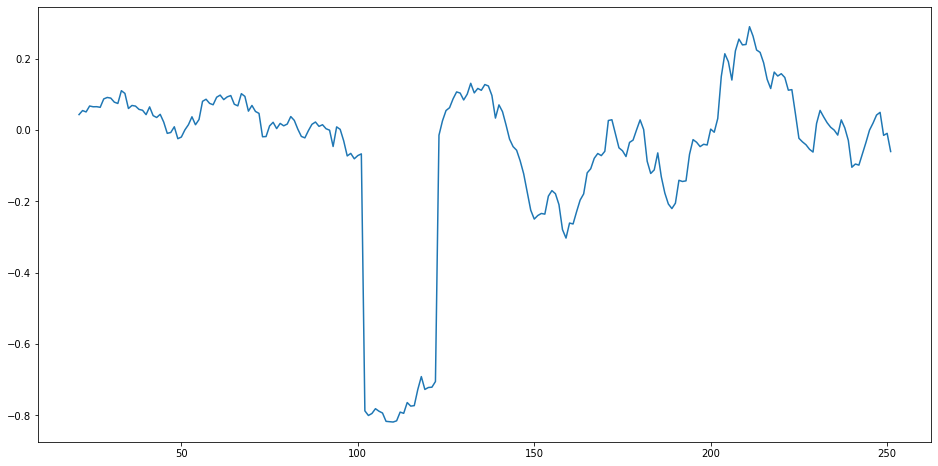

/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001332. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:      6,   Neg. LLF: 36558346.49032752
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1013.2082208730715
Iteration:      3,   Func. Count:     26,   Neg. LLF: 123972.93318803904
Iteration:      4,   Func. Count:     36,   Neg. LLF: 1502.7167233667146
Iteration:      5,   Func. Count:     45,   Neg. LLF: -150.2483552014959
Iteration:      6,   Func. Count:     53,   Neg. LLF: -236.04298173788692
Iteration:      7,   Func. Count:     58,   Neg. LLF: 131423.67520952495
Iteration:      8,   Func. Count:     64,   Neg. LLF: -224.04271658199923
Iteration:      9,   Func. Count:     70,   Neg. LLF: -124.97981623882798
Iteration:     10,   Func. Count:     77,   Neg. LLF: -236.89452224844172
Iteration:     11,   Func. Count:     82,   Neg. LLF: -236.89641969580356
Iteration:     12,   Func. Count:     87,   Neg. LLF: -236.89643586293013
Iteration:     13,   Func. Count:     91,   Neg. LLF: -236.89643586288568
Optimization terminated successfully    (Exit

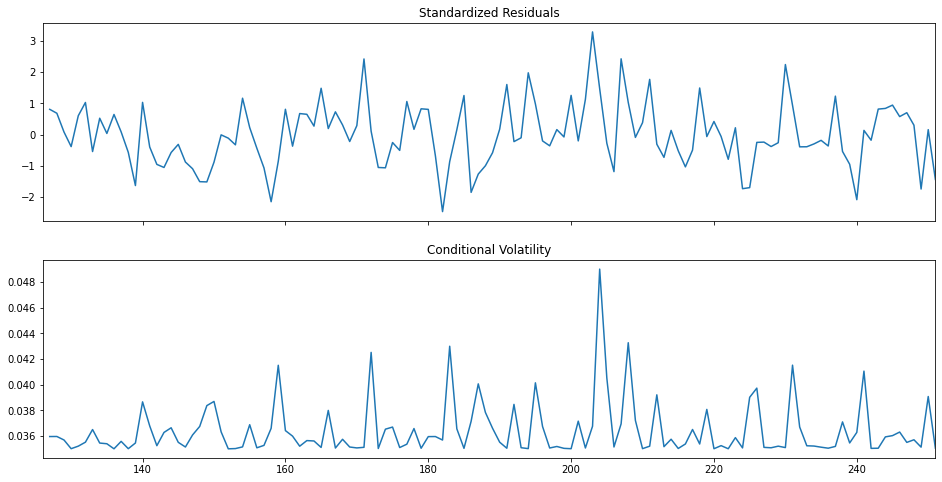

In [320]:
plt.plot(data['c'])
plt.show()
ar=arch_model(data['c'].iloc[105:], mean='AR', lags=1, vol='Garch', p=1, q=0)
res=ar.fit()
print(res.summary())
res.plot()
plt.show()


In [294]:
#for specified stock, test parameter space to find minimum AIC.

stock='a'

#data=data.iloc[105:]

models=[]
models.append(arch_model(data[stock], mean='Constant', vol='Garch', p=1, q=0))
models.append(arch_model(data[stock], mean='Constant', vol='Garch', p=2, q=0))
models.append(arch_model(data[stock], mean='Constant', vol='Garch', p=3, q=0))
models.append(arch_model(data[stock], mean='Constant', vol='Garch', p=1, q=1))
models.append(arch_model(data[stock], mean='Constant', vol='Garch', p=2, q=1))#5
models.append(arch_model(data[stock], mean='Constant', vol='Garch', p=3, q=1))
models.append(arch_model(data[stock], mean='AR', lags=1, vol='Garch', p=1, q=0))
models.append(arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=1, q=0))
models.append(arch_model(data[stock], mean='AR', lags=3, vol='Garch', p=1, q=0))
models.append(arch_model(data[stock], mean='AR', lags=1, vol='Garch', p=2, q=0))#10
models.append(arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=2, q=0))
models.append(arch_model(data[stock], mean='AR', lags=3, vol='Garch', p=2, q=0))
models.append(arch_model(data[stock], mean='AR', lags=1, vol='Garch', p=3, q=0))
models.append(arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=3, q=0))
models.append(arch_model(data[stock], mean='AR', lags=3, vol='Garch', p=3, q=0))#15
models.append(arch_model(data[stock], mean='AR', lags=1, vol='Garch', p=1, q=1))
models.append(arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=1, q=1))
models.append(arch_model(data[stock], mean='AR', lags=3, vol='Garch', p=1, q=1))
models.append(arch_model(data[stock], mean='AR', lags=1, vol='Garch', p=2, q=1))
models.append(arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=2, q=1))#20
models.append(arch_model(data[stock], mean='AR', lags=3, vol='Garch', p=2, q=1))
models.append(arch_model(data[stock], mean='AR', lags=1, vol='Garch', p=3, q=1))
models.append(arch_model(data[stock], mean='AR', lags=2, vol='Garch', p=3, q=1))
models.append(arch_model(data[stock], mean='AR', lags=3, vol='Garch', p=3, q=1))
              
AIC=[]
for model in models:
    res=model.fit(disp='off')
    AIC.append(res.aic)
    
print(np.asarray(AIC))
print(np.argmin(np.asarray(AIC))+1)


/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_sc

/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(ori

[ -786.16629661  -784.16629627  -782.16629602  -784.16629677
  -782.16629613  -780.16629679 -1117.79416994 -1100.33130026
 -1092.75382578 -1117.19130265 -1134.55000017 -1128.34472906
 -1115.19130277 -1132.55000019 -1126.34472867 -1116.76504907
 -1133.60495053 -1126.21445711 -1114.10114233 -1133.2626151
 -1126.34472912 -1111.87751793 -1129.2011902  -1121.8220108 ]
11


/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/brandon/.local/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003985. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(ori